In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import confusion_matrix, classification_report
import matplotlib.pyplot as plt
import seaborn as sns
import os
from tqdm import tqdm
from torch.utils.data import DataLoader
from time import time
import random
import json
import argparse

from data_loader import SeqDataLoader
from models.CNN_LSTM import CNN_LSTM
from models.Res_CNN_LSTM import Res_CNN_LSTM
from models.Res_SE_CNN_LSTM import Res_SE_CNN_LSTM
from models.SE_CNN_LSTM import SE_CNN_LSTM
from models.LSTMPredictor import LSTMPredictor


In [2]:
def set_global_seed(seed=42):
    # 设置 Python 的随机种子
    random.seed(seed)
    # 设置 NumPy 的随机种子
    np.random.seed(seed)
    # 设置 PyTorch 的 CPU 随机种子
    torch.manual_seed(seed)
    # 设置 PyTorch 的 CUDA 随机种子
    if torch.cuda.is_available():
        torch.cuda.manual_seed(seed)
        torch.cuda.manual_seed_all(seed)
        # 禁用 CUDA 卷积操作的非确定性算法
        torch.backends.cudnn.deterministic = True
        # 禁用 CUDA 卷积操作的自动寻找最优算法
        torch.backends.cudnn.benchmark = False

set_global_seed()

In [3]:

# config_path = './run_swat.json'
# if not os.path.exists(config_path):
#     raise FileNotFoundError(f"Config file not found: {config_path}")
if not os.path.exists('./checkpoints'):
    os.makedirs('./checkpoints')
# with open(config_path, 'r') as f:
#     config = json.load(f)
# model_list = [Res_SE_CNN_LSTM 0, Res_CNN_LSTM 1, CNN_LSTM 2, SE_CNN_LSTM 3, LSTMPredictor 4]

config = {
    "dataset_args": {
        "dataset": "swat",
        "train_data_path": "./dataset/swat/train.csv",
        "test_data_path": "./dataset/swat/test.csv",
        "winsize": 30,
        "step": 10
    },
    "model_args": {
        "model": 0,
        "input_dim": 51,
        
        "cnn1": 64,
        "k1": 5,
        "pad1": 2,
        "SEratio1": 4,
        "maxpool1": 2,

        "cnn2": 32,
        "k2": 5,
        "pad2": 2,
        "maxpool2": 2,
        "SEratio2": 4,

        "hidden_dim": 32,
        "lstm_layers": 1
    },
    "training_args": {
        "model_dir": None,
        "lr": 0.01,
        "epochs": 10,
        "batch_size": 32,
        "AE_MODEL": False,
        "threshold": 0.5
    }
}

dataset_args = config["dataset_args"]
model_args = config["model_args"]
training_args = config["training_args"]

AE_MODEL = training_args["AE_MODEL"]   # 是否是自编码器模型

# 检测是否有可用的GPU
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", device)

Using device: cpu


In [4]:

"""数据加载"""
dataset_name = dataset_args["dataset"]
train_data = SeqDataLoader(dataset_path=dataset_args["train_data_path"], win_size=dataset_args["winsize"], step=dataset_args["step"], name=f"{dataset_name} Train")
print(f'Train data length: {len(train_data)}')
print('Data sample shape:', train_data[0][0].shape)

"""数据加载"""
dataset_name = dataset_args["dataset"]
test_data = SeqDataLoader(dataset_path=dataset_args["test_data_path"], win_size=dataset_args["winsize"], step=1, name=f"{dataset_name} Test")
y_true = test_data.get_test_labels()
print(f'Test data length {len(test_data)}')
print(f'Test set Normal : {np.sum(y_true == 0)}; Attack : {np.sum(y_true == 1)}')
print('Data sample shape:', test_data[0][0].shape)
y_true_1 = np.where(y_true==1)[0]
print(len(y_true_1))

Loading swat Train data, window size is 30, step is 10
swat Train data shape: (495000, 51)
Train data length: 49497
Data sample shape: (30, 51)
Loading swat Test data, window size is 30, step is 1
swat Test data shape: (449919, 51)
Test data length 449889
Test set Normal : 395298; Attack : 54621
Data sample shape: (30, 51)
54621


Res_SE_CNN_LSTM


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 0, batch 0, loss: 0.6789793968200684
Epoch 0, batch 500, loss: 0.0478987917304039
Epoch 0, batch 1000, loss: 0.053069863468408585
Epoch 0, batch 1500, loss: 0.04575585201382637


 10%|█         | 1/10 [00:21<03:09, 21.10s/it]

Epoch 1, batch 0, loss: 0.11378072202205658
Epoch 1, batch 500, loss: 0.03499190881848335
Epoch 1, batch 1000, loss: 0.11316529661417007
Epoch 1, batch 1500, loss: 0.11549369245767593


 20%|██        | 2/10 [01:00<04:16, 32.12s/it]

Epoch 2, batch 0, loss: 0.05814152956008911
Epoch 2, batch 500, loss: 0.10090263187885284
Epoch 2, batch 1000, loss: 0.05438443645834923
Epoch 2, batch 1500, loss: 0.11292564123868942


 30%|███       | 3/10 [01:47<04:30, 38.65s/it]

Epoch 3, batch 0, loss: 0.09449093043804169
Epoch 3, batch 500, loss: 0.1461789757013321
Epoch 3, batch 1000, loss: 0.04158483445644379
Epoch 3, batch 1500, loss: 0.05785081535577774


 40%|████      | 4/10 [02:45<04:38, 46.38s/it]

Epoch 4, batch 0, loss: 0.0987330973148346
Epoch 4, batch 500, loss: 0.05609847605228424
Epoch 4, batch 1000, loss: 0.144624724984169
Epoch 4, batch 1500, loss: 0.02301306277513504


 50%|█████     | 5/10 [03:32<03:53, 46.65s/it]

Epoch 5, batch 0, loss: 0.06903994828462601
Epoch 5, batch 500, loss: 0.031424205750226974
Epoch 5, batch 1000, loss: 0.059328243136405945
Epoch 5, batch 1500, loss: 0.03349621593952179


 60%|██████    | 6/10 [04:24<03:13, 48.46s/it]

Epoch 6, batch 0, loss: 0.05426241457462311
Epoch 6, batch 500, loss: 0.10872115194797516
Epoch 6, batch 1000, loss: 0.11072631180286407
Epoch 6, batch 1500, loss: 0.03318896144628525


 70%|███████   | 7/10 [05:17<02:29, 49.93s/it]

Epoch 7, batch 0, loss: 0.05660827457904816
Epoch 7, batch 500, loss: 0.10629947483539581
Epoch 7, batch 1000, loss: 0.03382226824760437
Epoch 7, batch 1500, loss: 0.10787180066108704


 80%|████████  | 8/10 [06:16<01:45, 52.75s/it]

Epoch 8, batch 0, loss: 0.06970276683568954
Epoch 8, batch 500, loss: 0.024031987413764
Epoch 8, batch 1000, loss: 0.023964816704392433
Epoch 8, batch 1500, loss: 0.05781259760260582


 90%|█████████ | 9/10 [07:18<00:55, 55.72s/it]

Epoch 9, batch 0, loss: 0.05451563745737076
Epoch 9, batch 500, loss: 0.030239634215831757
Epoch 9, batch 1000, loss: 0.030257772654294968
Epoch 9, batch 1500, loss: 0.03448532521724701


100%|██████████| 10/10 [08:20<00:00, 50.07s/it]


Model saved to ./checkpoints/Res_SE_CNN_LSTM_swat_1743256812.pth


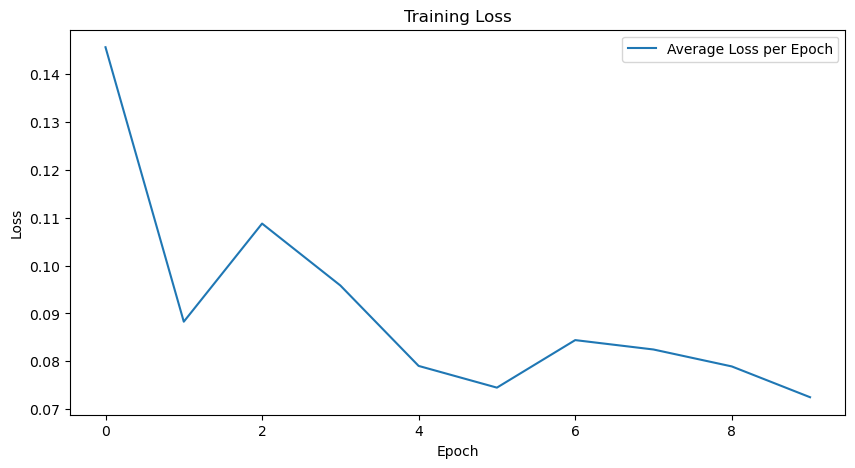

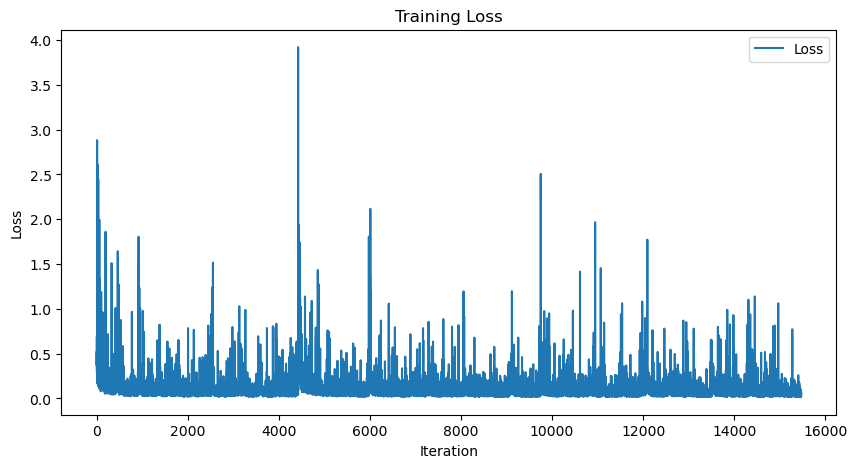

Config saved to ./checkpoints/Res_SE_CNN_LSTM_swat_1743256812.json


In [5]:

"""模型创建"""
data_dim = train_data[0][0].shape[-1]
model_list = [Res_SE_CNN_LSTM, Res_CNN_LSTM, CNN_LSTM, SE_CNN_LSTM, LSTMPredictor]
model = model_list[model_args["model"]](model_args)  # 选择模型
# model = SE_CNN_LSTM(model_args)  # 选择模型
print(model.ModelName)
model.to(device)  # 将模型移动到GPU上

filenameWithoutExt = f'{model.ModelName}_{dataset_args["dataset"]}_{int(time())}'

"""模型训练"""
learning_rate = training_args["lr"]
num_epochs = training_args["epochs"]
batch_size = training_args["batch_size"]
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=learning_rate, weight_decay=5e-4)
data_loader = DataLoader(train_data, batch_size=batch_size, shuffle=True)
# 训练循环，显示进度条
losses = []
model.train()
for epoch in tqdm(range(num_epochs)):
    for i, (x, x_1) in enumerate(data_loader):
        optimizer.zero_grad()
        x = x.to(device)  # 将数据移动到GPU上
        x_1 = x_1.to(device)  # 将数据移动到GPU上
        y = model(x)
        if AE_MODEL:
            loss = criterion(y[:,-1,:], x[:,-1,:])  # 自编码器的目标是重构，用窗口内的最后一步比较误差
        else:
            loss = criterion(y, x_1)  # 下一步的数据作为预测目标
        loss.backward()
        optimizer.step()

        losses.append(loss.item())
        if i % 500 == 0:
            print(f'Epoch {epoch}, batch {i}, loss: {loss.item()}')
# 保存模型
torch.save(model.state_dict(), f"./checkpoints/{filenameWithoutExt}.pth")
config["training_args"]["model_dir"] = f"./checkpoints/{filenameWithoutExt}.pth"
print(f"Model saved to ./checkpoints/{filenameWithoutExt}.pth")
# 每个epoch的平均损失
avg_loss = [np.mean(losses[i:i+len(data_loader)]) for i in range(0, len(losses), len(data_loader))]
# 绘制训练损失曲线
plt.figure(figsize=(10, 5))
plt.plot(avg_loss, label='Average Loss per Epoch')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training Loss')
plt.legend()
plt.show()
# 绘图
plt.figure(figsize=(10, 5))
plt.plot(losses, label='Loss')
plt.xlabel('Iteration')
plt.ylabel('Loss')
plt.title('Training Loss')
plt.legend()
plt.show()


"""结果保存"""
# 保存超参数结果到json文件
with open(f'./checkpoints/{filenameWithoutExt}.json', 'w') as f:
    json.dump({'args': config}, f, indent=4)
    print(f"Config saved to ./checkpoints/{filenameWithoutExt}.json")


100%|██████████| 1547/1547 [00:28<00:00, 53.69it/s]


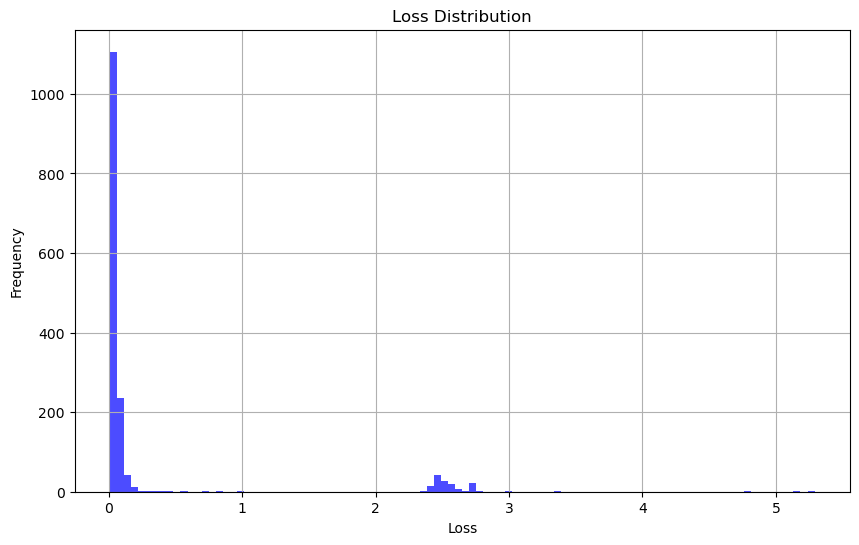

In [6]:
model.eval()
losses4train = []
with torch.no_grad():
    for x, x_1 in tqdm(data_loader):
        x = x.to(device)
        x_1 = x_1.to(device)
        y = model(x)
        if AE_MODEL:
            loss = criterion(y[:,-1,:], x[:,-1,:])     # 自编码器的目标是重构，用窗口内的最后一步比较误差
        else:
            loss = criterion(y, x_1)     # 下一步的数据作为预测目标

        losses4train.append(loss.item())

# 绘制误差数值分布，以便选择阈值
plt.figure(figsize=(10, 6))
plt.hist(losses4train, bins=100, color='blue', alpha=0.7)
plt.title('Loss Distribution')
plt.xlabel('Loss')
plt.ylabel('Frequency')
plt.grid()
plt.savefig(f"./checkpoints/{filenameWithoutExt}_loss_distribution.png")
plt.show()


In [12]:
criterion = nn.MSELoss()
a = np.random.rand(51)
b = np.random.rand(51)
criterion(torch.tensor(a), torch.tensor(b))

tensor(0.2006, dtype=torch.float64)

In [13]:
"""滚动预测
对模型输入窗口大小数据，预测下一步，若误差超过阈值，则标记为异常，且将数据中的下一步替换为预测值，继续预测下一步
"""
threshold = 1.0  # 选择阈值
criterion = nn.MSELoss()
test_data_list = test_data.get_test_data()
y_pred = np.zeros(len(test_data_list))
with torch.no_grad():
    for i in tqdm(range(len(test_data_list)-dataset_args["winsize"])):
        x = test_data_list[i:i+dataset_args["winsize"]]
        x = torch.tensor(x, dtype=torch.float32).to(device)
        x = x.unsqueeze(0)
        y_1 = test_data_list[i+dataset_args["winsize"]]
        y = model(x)
        y = y.squeeze(0).numpy()
        loss = criterion(torch.tensor(y), torch.tensor(y_1)).item()
        if loss > threshold:
            test_data_list[i+dataset_args["winsize"]] = y
            y_pred[i+dataset_args["winsize"]] = 1


100%|██████████| 449889/449889 [12:02<00:00, 623.01it/s]


In [15]:
print(classification_report(y_true, y_pred, target_names=['Normal', 'Attack']))

              precision    recall  f1-score   support

      Normal       0.95      0.41      0.58    395298
      Attack       0.17      0.85      0.28     54621

    accuracy                           0.47    449919
   macro avg       0.56      0.63      0.43    449919
weighted avg       0.86      0.47      0.54    449919



100%|██████████| 7030/7030 [04:15<00:00, 27.51it/s]


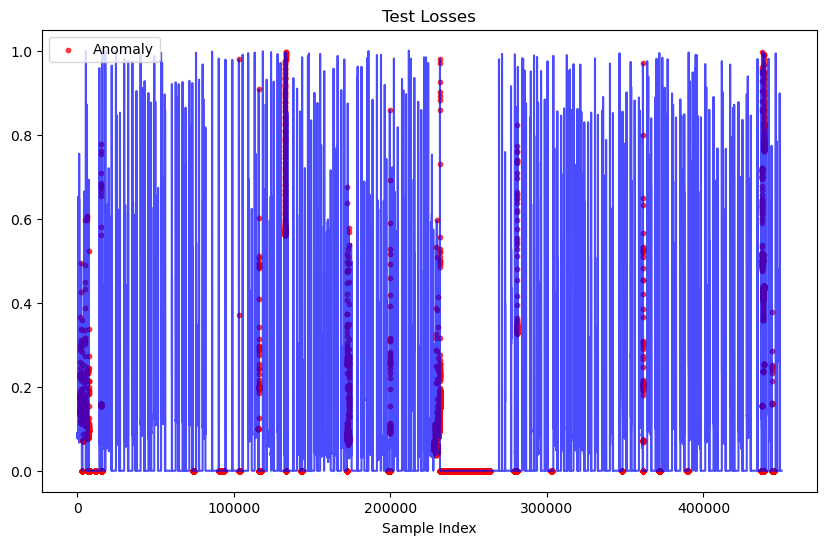

In [16]:

"""模型评估"""
test_losses = []
criterion = nn.MSELoss(reduction='none')
test_data_loader = DataLoader(test_data, batch_size=64, shuffle=False)  # 评估所用batch_size不影响
with torch.no_grad():
    for x, x_1 in tqdm(test_data_loader):
        x = x.to(device)
        x_1 = x_1.to(device)
        y = model(x)
        if AE_MODEL:
            loss = criterion(y[:,-1,:], x[:,-1,:]).mean(dim=1)     # 自编码器的目标是重构，用窗口内的最后一步比较误差
        else:
            loss = criterion(y, x_1).mean(dim=1)     # 下一步的数据作为预测目标

        test_losses += loss.tolist()

# 绘图
plt.figure(figsize=(10, 6))
plt.plot(test_losses, color='blue', alpha=0.7)
plt.scatter(y_true_1, np.array(test_losses)[y_true_1], color='red', label='Anomaly', alpha=0.7, s=10)
plt.title('Test Losses')
plt.xlabel('Sample Index')
plt.legend()



In [ ]:
config["training_args"]["threshold"] = 0.4
text = []
# thresholds = np.percentile(test_losses, [80, 85, 90, 95, 99]).tolist()
thresholds = np.arange(0.4, 1.51, 0.1).tolist()
# thresholds += [config["training_args"]["threshold"]]  

for threshold in thresholds:
    y_pred = (np.array(test_losses) > threshold).astype(int)
    if AE_MODEL:    
        y_pred = np.concatenate([np.zeros(dataset_args["winsize"]-1), y_pred]) # 自编码器的预测是窗口内的最后一步
        y_pred = np.concatenate([y_pred, np.zeros(1)])     # 由于数据集构造是面向预测的，最后一步不在训练集里面
    else:
        y_pred = np.concatenate([np.zeros(dataset_args["winsize"]), y_pred])  # 预测下一步
    text.append(f'threshold: {threshold}\n' + classification_report(y_true, y_pred, target_names=['Normal', 'Attack']) + '\n')
    print(text[-1])

"""结果保存"""
# 保存评估结果到json文件
with open(f'./checkpoints/{filenameWithoutExt}.json', 'w') as f:
    json.dump({'args': config, 'classification_report': text}, f, indent=4)